## Importations

In [1]:
import mne
import os
import scipy.stats
import matplotlib.pyplot as plt
import numpy as np
import pickle
from src.utils import get_bids_file
from src.params import RESULT_PATH, SUBJ_LIST, ACTIVE_RUN, FIG_PATH, EVENTS_ID
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mne.viz import plot_compare_evokeds

In [11]:
# Remove plot for compute canada
def plot_ERP(condition1, condition2, cond1_name, cond2_name, picks) :
    print(condition1)
    print(condition2)
    
    condition1.pick_types(meg=True, ref_meg = False,  exclude='bads')
    condition2.pick_types(meg=True, ref_meg = False,  exclude='bads')
    
    condition1=condition1.average()
    condition2=condition2.average()
    
    # Plot each condition separately
    fig_cond1 = condition1.plot_joint(picks = picks)
    fname_cond1 = FIG_PATH + "plot-join_cond-" + cond1_name
    fig_cond1.savefig(fname_cond1)
    plt.show()

    fig_cond2 = condition2.plot_joint(picks = picks)
    fname_cond2 = FIG_PATH + "plot-join_cond-" + cond2_name
    fig_cond2.savefig(fname_cond2)
    plt.show()

    # Plot ERPs LaughReal vs LaughPosed
    evoked = dict(real = condition1, posed = condition2)
    mne.viz.plot_compare_evokeds(evoked, picks = picks, combine='mean', time_unit='ms')
    fname_ERP = FIG_PATH + "ERP_cond1-" + cond1_name + "_cond2-" + cond2_name
    plt.savefig(fname_ERP) # Doesn't work
    plt.show()


In [3]:
def visualize_cluster(epochs, cluster_stats, event_id, task, conditions, cond1, cond2) :
    epochs.pick_types(meg=True, ref_meg = False,  exclude='bads')
    F_obs, clusters, p_values, _ = cluster_stats
    
    p_accept = 0.05
    good_cluster_inds = np.where(p_values < p_accept)[0]
    print("Good cluster :", good_cluster_inds)

    # configure variables for visualization
    colors = {cond1: "crimson", cond2: 'steelblue'}

    # organize data for plotting
    evokeds = {cond: epochs[cond].average() for cond in event_id}
               
    # loop over clusters
    for i_clu, clu_idx in enumerate(good_cluster_inds):
        # unpack cluster information, get unique indices
        time_inds, space_inds = np.squeeze(clusters[clu_idx])
        ch_inds = np.unique(space_inds)
        time_inds = np.unique(time_inds)

        # get topography for F stat
        f_map = F_obs[time_inds, ...].mean(axis=0)

        # get signals at the sensors contributing to the cluster
        sig_times = epochs.times[time_inds]

        # create spatial mask
        mask = np.zeros((f_map.shape[0], 1), dtype=bool)
        mask[ch_inds, :] = True

        # initialize figure
        fig, ax_topo = plt.subplots(1, 1, figsize=(10, 3))

        # plot average test statistic and mark significant sensors
        f_evoked = mne.EvokedArray(f_map[:, np.newaxis], epochs.info, tmin=0)
        f_evoked.plot_topomap(times=0, mask=mask, axes=ax_topo, cmap='Reds',
                              vlim=(np.min, np.max), show=False,
                              colorbar=False, mask_params=dict(markersize=10))

        image = ax_topo.images[0]

        # remove the title that would otherwise say "0.000 s"
        ax_topo.set_title("")

        # create additional axes (for ERF and colorbar)
        divider = make_axes_locatable(ax_topo)

        # add axes for colorbar
        ax_colorbar = divider.append_axes('right', size='5%', pad=0.05)
        plt.colorbar(image, cax=ax_colorbar)
        ax_topo.set_xlabel(
            'Averaged F-map ({:0.3f} - {:0.3f} s)'.format(*sig_times[[0, -1]]))

        # add new axis for time courses and plot time courses
        ax_signals = divider.append_axes('right', size='300%', pad=1.2)
        title = 'Cluster #{0}, {1} sensor'.format(i_clu + 1, len(ch_inds))
        if len(ch_inds) > 1:
            title += "s (mean)"
        plot_compare_evokeds(evokeds, title=title, picks=ch_inds, axes=ax_signals,
                             colors=colors, show=False,
                             split_legend=True, truncate_yaxis='auto')

        # plot temporal cluster extent
        ymin, ymax = ax_signals.get_ylim()
        ax_signals.fill_betweenx((ymin, ymax), sig_times[0], sig_times[-1],
                                 color='orange', alpha=0.3)

        # clean up viz
        mne.viz.tight_layout(fig=fig)
        fig.subplots_adjust(bottom=.05)
        fig.savefig(FIG_PATH + '/erp/sub-all_run-all_task-{}_cond-{}_meas-cluster_erp.png'.format(task, conditions))
        plt.show()

In [12]:
# Select what conditions to compute
task = "LaughterActive"
cond1 = "LaughReal"
cond2 = "LaughPosed"
conditions = cond1 + '-' + cond2
condition_list = [cond1, cond2]
event_id = dict()
picks = "meg" # Select MEG channels

<EpochsArray |  75 events (all good), -0.5 - 1.5 sec, baseline -0.5 – 0 sec, ~460.2 MB, data loaded, with metadata,
 'LaughReal': 75>
<EpochsArray |  75 events (all good), -0.5 - 1.5 sec, baseline -0.5 – 0 sec, ~460.2 MB, data loaded, with metadata,
 'LaughPosed': 75>
Removing 5 compensators from info because not all compensation channels were picked.
Removing 5 compensators from info because not all compensation channels were picked.
No projector specified for this dataset. Please consider the method self.add_proj.


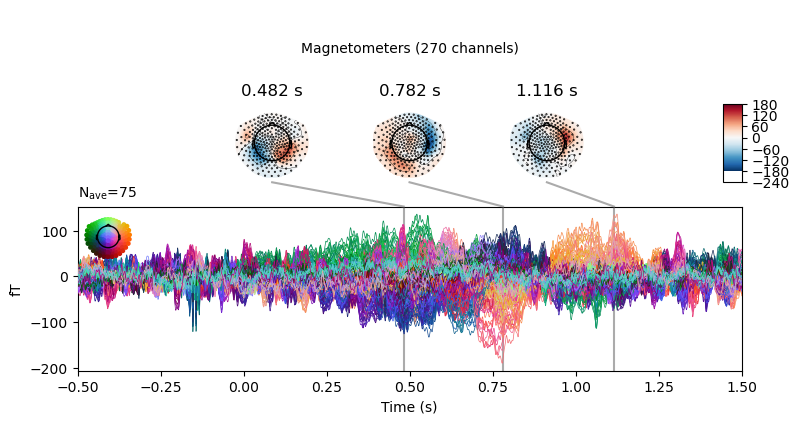

No projector specified for this dataset. Please consider the method self.add_proj.


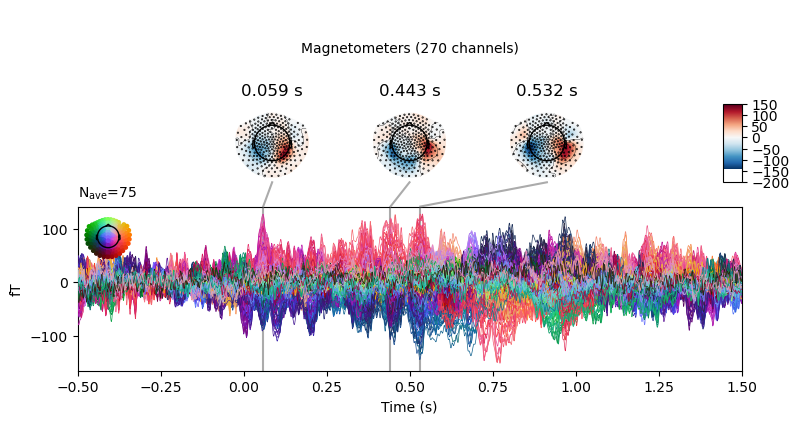

combining channels using "mean"
combining channels using "mean"


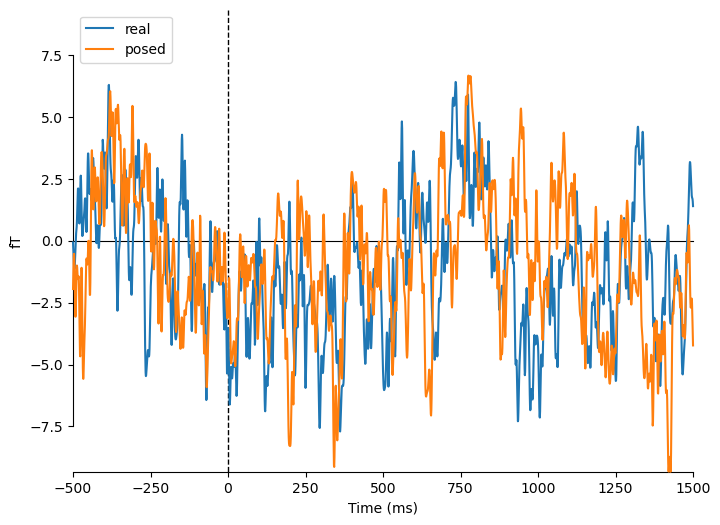

<Figure size 640x480 with 0 Axes>

In [13]:
# TODO : Need to put that in params
_, save_cond1 = get_bids_file(RESULT_PATH, task=task, stage = "erp", condition=cond1)
_, save_cond2 = get_bids_file(RESULT_PATH, task=task, stage = "erp", condition=cond2)

# Need to get the files
with open(save_cond1, "rb") as f:
    condition1 = pickle.load(f)

with open(save_cond2, "rb") as f:
    condition2 = pickle.load(f)

# Plot ERPs
plot_ERP(condition1, condition2, cond1, cond2, picks)

In [6]:
_, save_concat = get_bids_file(RESULT_PATH, task=task, stage = "erp-concat", condition=conditions)

_, save_cluster_stats = get_bids_file(RESULT_PATH, task=task, stage = "erp-clusters", measure="cluster-stats", condition = conditions)

with open(save_concat, "rb") as f:
    epochs_concat = pickle.load(f)

with open(save_cluster_stats, 'rb') as f:
    cluster_stats = pickle.load(f)

for ev in EVENTS_ID :
    for conds in condition_list :
        if conds not in EVENTS_ID :
            raise Exception("Condition is not an event")
        if conds == ev :
            event_id[conds] = EVENTS_ID[ev]

print("=> Process task :", task, "for conditions :", cond1, "&", cond2)

# Visualization of ERP clusters
visualize_cluster(epochs_concat, cluster_stats, event_id, task, conditions, cond1, cond2)

=> Process task : LaughterPassive for conditions : LaughReal & LaughPosed


NameError: name 'epochs_concat' is not defined